[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/UVADS/DS1001/blob/master/ddsbook/analytics-lab-III.ipynb) 

## Overview

#### The goal of this lab is provide you with a better understand of how machine learning models work. The model you will be building is a supervised classification model, k nearest neighbor (kNN). This notebook will walk you through a shorten series of steps necessary to prepare the data, build the model, evaluated the output and visualize the predictions. You'll need to run all the cells to make the model work correctly. Do so one at a time, in order, by pressing the play button in the top left corner of each cell.

#### You will then be asked to interpret and manipulate the model features with the goal of better understanding how kNN generates it's predictions. The lab will focus on the concepts of over/under fitting and how kNN generates probability estimates.

## Dataset

#### The data we will be using is the cereal dataset from the UCI Machine Learning Repository. The dataset contains 77 observations of 16 variables. The goal of this lab is to build a kNN model that can predict the target variable based on the 15 predictor variables.

# Part 1: Data Preparation and Model Building

### Load the Libraries

In [15]:
#First we import the libraries we need
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt

### Load the Dataset

In [79]:
#read in the cereal dataset, we are reading the data in from a URL associated with the Foundations of 
#machine learning class

cereal = pd.read_csv("https://raw.githubusercontent.com/UVADS/DS-3001/main/data/cereal.csv")

cereal.info() # Let's check the structure of the dataset and see if we have any issues with variable classes
#usually it's converting things to category

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      77 non-null     object 
 1   mfr       77 non-null     object 
 2   type      77 non-null     object 
 3   calories  77 non-null     int64  
 4   protein   77 non-null     int64  
 5   fat       77 non-null     int64  
 6   sodium    77 non-null     int64  
 7   fiber     77 non-null     float64
 8   carbo     77 non-null     float64
 9   sugars    77 non-null     int64  
 10  potass    77 non-null     int64  
 11  vitamins  77 non-null     int64  
 12  shelf     77 non-null     int64  
 13  weight    77 non-null     float64
 14  cups      77 non-null     float64
 15  rating    77 non-null     float64
dtypes: float64(5), int64(8), object(3)
memory usage: 9.8+ KB


### Scale/Normalizing/Variable Classes (lots more but these are the focus of this lab)


In [80]:
#Looks like columns 1,2,11 and 12 need to be converted to category

Column_index_list = [1,2,11,12]
cereal.iloc[:,Column_index_list]= cereal.iloc[:,Column_index_list].astype('category') 
#iloc accesses the index of a dataframe, bypassing having to manually type in the names of each column

cereal.dtypes #another way of checking the structure of the dataset. Simpler, but does not give an index

name          object
mfr         category
type        category
calories       int64
protein        int64
fat            int64
sodium         int64
fiber        float64
carbo        float64
sugars         int64
potass         int64
vitamins    category
shelf       category
weight       float64
cups         float64
rating       float64
dtype: object

In [81]:
#Let's take a closer look at mfr
cereal.mfr.value_counts() #value_counts() simply displays variable counts as a vertical table.

K    23
G    22
P     9
Q     8
R     8
N     6
A     1
Name: mfr, dtype: int64

### Example of how to collapse categories

In [82]:
#Usually don't want more than 5ish groups, so we should collapse this factor  
#Keep the large groups (G, K) and group all the smaller categories as "Other"

top = ['K','G']
cereal.mfr = (cereal.mfr.apply(lambda x: x if x in top else "Other")).astype('category')
#lambda is a small anonymous function that can take any number of arguments but can only have one expression
#a example lambda function is lambda a: a+10, if we passed 5 to this we would get back 15
#lambda functions are best used inside of another function, like in this example when it is used inside the apply function
#to use an if function in a lambda statement, the True return value comes first (x), then the if statement, then else, and then the False return

cereal.mfr.value_counts() #This is a lot better

Other    32
K        23
G        22
Name: mfr, dtype: int64

### Normalizing the numeric values 

In [83]:
# Here we are normalizing the numeric values and creating a index based on numeric columns:
abc = list(cereal.select_dtypes('number')) #select function to find the numeric variables and create a list  

cereal[abc] = MinMaxScaler().fit_transform(cereal[abc])
cereal #notice the difference in the range of values for the numeric variables

name    mfr type  calories  protein  fat    sodium  \
0                   100% Bran  Other    C  0.181818      0.6  0.2  0.406250   
1           100% Natural Bran  Other    C  0.636364      0.4  1.0  0.046875   
2                    All-Bran      K    C  0.181818      0.6  0.2  0.812500   
3   All-Bran with Extra Fiber      K    C  0.000000      0.6  0.0  0.437500   
4              Almond Delight  Other    C  0.545455      0.2  0.4  0.625000   
..                        ...    ...  ...       ...      ...  ...       ...   
72                    Triples      G    C  0.545455      0.2  0.2  0.781250   
73                       Trix      G    C  0.545455      0.0  0.2  0.437500   
74                 Wheat Chex  Other    C  0.454545      0.4  0.2  0.718750   
75                   Wheaties      G    C  0.454545      0.4  0.2  0.625000   
76        Wheaties Honey Gold      G    C  0.545455      0.2  0.2  0.625000   

       fiber     carbo  sugars    potass vitamins shelf  weight   cups  \
0   0.714286  0.250000  0.4375  0.848943       25     3     0.5  0.064   
1   0.142857  0.375000  0.5625  0.410876        0     3     0.5  0.600   
2   0.642857  0.333333  0.3750  0.969789       25     3     0.5  0.064   
3   1.000000  0.375000  0.0625  1.000000       25     3     0.5  0.200   
4   0.071429  0.625000  0.5625  0.000000       25     3     0.5  0.400   
..       ...       ...     ...       ...      ...   ...     ...    ...   
72  0.000000  0.916667  0.2500  0.184290       25     3     0.5  0.400   
73  0.000000  0.583333  0.8125  0.078550       25     2     0.5  0.600   
74  0.214286  0.750000  0.2500  0.350453       25     1     0.5  0.336   
75  0.214286  0.750000  0.2500  0.335347       25     1     0.5  0.600   
76  0.071429  0.708333  0.5625  0.184290       25     1     0.5  0.400   

      rating  
0   0.665593  
1   0.210685  
2   0.546941  
3   1.000000  
4   0.215987  
..       ...  
72  0.278387  
73  0.128340  
74  0.419558  
75  0.443410  
76  0.239812  

[77 rows x 16 columns]

### One-Hot Encoding the categorical values

In [84]:
# Next let's one-hot encode those categorical variables

category_list = list(cereal.select_dtypes('category')) #select function to find the categorical variables and create a list  

cereal_1h = pd.get_dummies(cereal, columns = category_list) 
#get_dummies encodes categorical variables into binary by adding in indicator column for each group of a category 
#and assigning it 0 if false or 1 if true
cereal_1h #see the difference? This is one-hot encoding!

name  calories  protein  fat    sodium     fiber  \
0                   100% Bran  0.181818      0.6  0.2  0.406250  0.714286   
1           100% Natural Bran  0.636364      0.4  1.0  0.046875  0.142857   
2                    All-Bran  0.181818      0.6  0.2  0.812500  0.642857   
3   All-Bran with Extra Fiber  0.000000      0.6  0.0  0.437500  1.000000   
4              Almond Delight  0.545455      0.2  0.4  0.625000  0.071429   
..                        ...       ...      ...  ...       ...       ...   
72                    Triples  0.545455      0.2  0.2  0.781250  0.000000   
73                       Trix  0.545455      0.0  0.2  0.437500  0.000000   
74                 Wheat Chex  0.454545      0.4  0.2  0.718750  0.214286   
75                   Wheaties  0.454545      0.4  0.2  0.625000  0.214286   
76        Wheaties Honey Gold  0.545455      0.2  0.2  0.625000  0.071429   

       carbo  sugars    potass  weight  ...  mfr_K  mfr_Other  type_C  type_H  \
0   0.250000  0.4375  0.848943     0.5  ...      0          1       1       0   
1   0.375000  0.5625  0.410876     0.5  ...      0          1       1       0   
2   0.333333  0.3750  0.969789     0.5  ...      1          0       1       0   
3   0.375000  0.0625  1.000000     0.5  ...      1          0       1       0   
4   0.625000  0.5625  0.000000     0.5  ...      0          1       1       0   
..       ...     ...       ...     ...  ...    ...        ...     ...     ...   
72  0.916667  0.2500  0.184290     0.5  ...      0          0       1       0   
73  0.583333  0.8125  0.078550     0.5  ...      0          0       1       0   
74  0.750000  0.2500  0.350453     0.5  ...      0          1       1       0   
75  0.750000  0.2500  0.335347     0.5  ...      0          0       1       0   
76  0.708333  0.5625  0.184290     0.5  ...      0          0       1       0   

    vitamins_0  vitamins_25  vitamins_100  shelf_1  shelf_2  shelf_3  
0            0            1             0        0        0        1  
1            1            0             0        0        0        1  
2            0            1             0        0        0        1  
3            0            1             0        0        0        1  
4            0            1             0        0        0        1  
..         ...          ...           ...      ...      ...      ...  
72           0            1             0        0        0        1  
73           0            1             0        0        1        0  
74           0            1             0        1        0        0  
75           0            1             0        1        0        0  
76           0            1             0        1        0        0  

[77 rows x 23 columns]

### Creating a binary target variable so we can run this model as a classification problem.

In [86]:
#add this as a predictor instead of replacing the numeric version, changing the target into a binary variable 
#to allow for classification 
cereal_1h['rating_f'] = pd.cut(cereal_1h.rating, bins = [-1,0.43,1], labels =[0,1])
#If we want two segments we input three numbers, start, cut and stop values

cereal_1h #notice the new column rating_f, it is now binary based on if the continuous value is above 0.43 or not

name  calories  protein  fat    sodium     fiber  \
0                   100% Bran  0.181818      0.6  0.2  0.406250  0.714286   
1           100% Natural Bran  0.636364      0.4  1.0  0.046875  0.142857   
2                    All-Bran  0.181818      0.6  0.2  0.812500  0.642857   
3   All-Bran with Extra Fiber  0.000000      0.6  0.0  0.437500  1.000000   
4              Almond Delight  0.545455      0.2  0.4  0.625000  0.071429   
..                        ...       ...      ...  ...       ...       ...   
72                    Triples  0.545455      0.2  0.2  0.781250  0.000000   
73                       Trix  0.545455      0.0  0.2  0.437500  0.000000   
74                 Wheat Chex  0.454545      0.4  0.2  0.718750  0.214286   
75                   Wheaties  0.454545      0.4  0.2  0.625000  0.214286   
76        Wheaties Honey Gold  0.545455      0.2  0.2  0.625000  0.071429   

       carbo  sugars    potass  weight  ...  mfr_Other  type_C  type_H  \
0   0.250000  0.4375  0.848943     0.5  ...          1       1       0   
1   0.375000  0.5625  0.410876     0.5  ...          1       1       0   
2   0.333333  0.3750  0.969789     0.5  ...          0       1       0   
3   0.375000  0.0625  1.000000     0.5  ...          0       1       0   
4   0.625000  0.5625  0.000000     0.5  ...          1       1       0   
..       ...     ...       ...     ...  ...        ...     ...     ...   
72  0.916667  0.2500  0.184290     0.5  ...          0       1       0   
73  0.583333  0.8125  0.078550     0.5  ...          0       1       0   
74  0.750000  0.2500  0.350453     0.5  ...          1       1       0   
75  0.750000  0.2500  0.335347     0.5  ...          0       1       0   
76  0.708333  0.5625  0.184290     0.5  ...          0       1       0   

    vitamins_0  vitamins_25  vitamins_100  shelf_1  shelf_2  shelf_3  rating_f  
0            0            1             0        0        0        1         1  
1            1            0             0        0        0        1         0  
2            0            1             0        0        0        1         1  
3            0            1             0        0        0        1         1  
4            0            1             0        0        0        1         0  
..         ...          ...           ...      ...      ...      ...       ...  
72           0            1             0        0        0        1         0  
73           0            1             0        0        1        0         0  
74           0            1             0        1        0        0         0  
75           0            1             0        1        0        0         1  
76           0            1             0        1        0        0         0  

[77 rows x 24 columns]

### Dropping Variables and Partitioning (Train/Test)

In [13]:
#Divide up our data into two parts, Training and Test but first we need to...
#clean up our dataset a bit by dropping the original rating variable and the cereal name since we can't really use them

cereal_dt = cereal_1h.drop(['name','rating'],axis=1) #creating a new dataframe so we don't delete these columns from our working environment. 
cereal_dt

calories  protein  fat    sodium     fiber     carbo  sugars    potass  \
0   0.181818      0.6  0.2  0.406250  0.714286  0.250000  0.4375  0.848943   
1   0.636364      0.4  1.0  0.046875  0.142857  0.375000  0.5625  0.410876   
2   0.181818      0.6  0.2  0.812500  0.642857  0.333333  0.3750  0.969789   
3   0.000000      0.6  0.0  0.437500  1.000000  0.375000  0.0625  1.000000   
4   0.545455      0.2  0.4  0.625000  0.071429  0.625000  0.5625  0.000000   
..       ...      ...  ...       ...       ...       ...     ...       ...   
72  0.545455      0.2  0.2  0.781250  0.000000  0.916667  0.2500  0.184290   
73  0.545455      0.0  0.2  0.437500  0.000000  0.583333  0.8125  0.078550   
74  0.454545      0.4  0.2  0.718750  0.214286  0.750000  0.2500  0.350453   
75  0.454545      0.4  0.2  0.625000  0.214286  0.750000  0.2500  0.335347   
76  0.545455      0.2  0.2  0.625000  0.071429  0.708333  0.5625  0.184290   

    weight   cups  ...  mfr_Other  type_C  type_H  vitamins_0  vitamins_25  \
0      0.5  0.064  ...          1       1       0           0            1   
1      0.5  0.600  ...          1       1       0           1            0   
2      0.5  0.064  ...          0       1       0           0            1   
3      0.5  0.200  ...          0       1       0           0            1   
4      0.5  0.400  ...          1       1       0           0            1   
..     ...    ...  ...        ...     ...     ...         ...          ...   
72     0.5  0.400  ...          0       1       0           0            1   
73     0.5  0.600  ...          0       1       0           0            1   
74     0.5  0.336  ...          1       1       0           0            1   
75     0.5  0.600  ...          0       1       0           0            1   
76     0.5  0.400  ...          0       1       0           0            1   

    vitamins_100  shelf_1  shelf_2  shelf_3  rating_f  
0              0        0        0        1         1  
1              0        0        0        1         0  
2              0        0        0        1         1  
3              0        0        0        1         1  
4              0        0        0        1         0  
..           ...      ...      ...      ...       ...  
72             0        0        0        1         0  
73             0        0        1        0         0  
74             0        1        0        0         0  
75             0        1        0        0         1  
76             0        1        0        0         0  

[77 rows x 22 columns]

In [17]:
# Now we partition
Train, Test = train_test_split(cereal_dt,  train_size = 55, stratify = cereal_dt.rating_f) 
#stratify perserves class proportions when splitting, reducing sampling error 

### Model Building Cell

In [88]:
import random
random.seed(1984)   # kNN is a random algorithm, so we use `random.seed(x)` to make results repeatable

X_train = Train.drop(['rating_f'], axis=1).values #features
y_train = Train['rating_f'].values #target

neigh = KNeighborsClassifier(n_neighbors=3) #this is the value to change
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

### Evaluation Cell

In [89]:
X_test = Test.drop(['rating_f'], axis=1).values
y_test = Test['rating_f'].values

neigh.score(X_test, y_test)

0.8636363636363636

## Task 1
##### Go back two cells to the "Model Building Cell" and change the value of k. Then rerun the "Evaluation cell". What happens to the accuracy of the model? Track the output of the model for odd values between 3 and 21. Note the changes by drawing a graph, by hand, of the *accuracy* versus k.

##### Using what we learning in class about over and under fitting explain what is happening to the model as we change the value of k, keeping in mind that the range of evaluation is between 0 and 1, with 1 being a perfect classification model.

##### Lastly recommend a value for k and explain why you recommend that value.

# Part 2: Probabilities of the Model

#### The model is predicting the probability of each observation belonging to each class. So for every row in the test dataset a probability is calculated for each class [0,1]. The class with the highest probability is the predicted class. So let's take a closer look at the probabilities. The next five cells are just getting the data organized so the results are easier to view.

In [35]:
# we want to make a table containing: probability, expected, and actual values

test_probs = neigh.predict_proba(X_test)
test_preds = neigh.predict(X_test)

In [37]:
# convert probabilities to pd df
test_probabilities = pd.DataFrame(test_probs, columns = ['bad_cereal_prob', 'good_cereal_prob'])
test_probabilities

bad_cereal_prob  good_cereal_prob
0               0.8               0.2
1               0.6               0.4
2               0.8               0.2
3               1.0               0.0
4               0.8               0.2
5               0.6               0.4
6               0.6               0.4
7               0.8               0.2
8               0.6               0.4
9               1.0               0.0
10              0.4               0.6
11              0.6               0.4
12              1.0               0.0
13              0.8               0.2
14              0.6               0.4
15              0.6               0.4
16              1.0               0.0
17              0.8               0.2
18              0.4               0.6
19              1.0               0.0
20              0.2               0.8
21              0.8               0.2

In [40]:
final_model = pd.DataFrame({'actual_class': y_test.tolist(),
                           'pred_class': test_preds.tolist(),
                           'pred_prob': [test_probabilities['good_cereal_prob'][i] if test_preds[i]==1 else test_probabilities['bad_cereal_prob'][i] for i in range(len(test_preds))]})
# that last line is some list comprehension -- to understand that here in particular click the following link:
# https://stackoverflow.com/questions/4260280/if-else-in-a-list-comprehension

final_model.head()

actual_class  pred_class  pred_prob
0             0           0        0.8
1             1           0        0.6
2             0           0        0.8
3             0           0        1.0
4             0           0        0.8

#### Now we are going to add the percentage of the probability for the positive class (good cereal) to the dataframe.

In [43]:
# add a column about the probability the observation is in the positive class
final_model['pos_pred'] = [final_model.pred_prob[i] if final_model.pred_class[i]==1 else 1-final_model.pred_prob[i] for i in range(len(final_model.pred_class))]

final_model #look at this dataframe for the first question in Task 2

actual_class  pred_class  pred_prob  pos_pred
0              0           0        0.8       0.2
1              1           0        0.6       0.4
2              0           0        0.8       0.2
3              0           0        1.0       0.0
4              0           0        0.8       0.2
5              0           0        0.6       0.4
6              0           0        0.6       0.4
7              0           0        0.8       0.2
8              1           0        0.6       0.4
9              0           0        1.0       0.0
10             1           1        0.6       0.6
11             1           0        0.6       0.4
12             0           0        1.0       0.0
13             0           0        0.8       0.2
14             0           0        0.6       0.4
15             0           0        0.6       0.4
16             0           0        1.0       0.0
17             0           0        0.8       0.2
18             1           1        0.6       0.6
19             0           0        1.0       0.0
20             1           1        0.8       0.8
21             0           0        0.8       0.2

In [87]:
# convert classes to categories
final_model.actual_class = final_model.actual_class.astype('category')
final_model.pred_class = final_model.pred_class.astype('category')

### Graph the probabilities

<AxesSubplot:xlabel='pos_pred', ylabel='Count'>

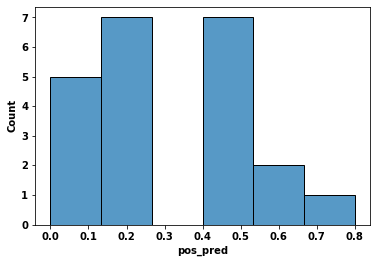

In [59]:
# create probability distribution graph
import seaborn as sns

sns.histplot(final_model, x="pos_pred")

## Task 2: Determine how the probabilities are calculated

##### First, looking at the "final model" dataframe from three cells above, list the rows that have errors in the classification. 

##### Use the code below to again adjust the k value in the "Second Model Building Cell" and the run the "Graph Cell". Use the same range of values as you did in Task 1. This time look at the graph and note the changes. Then based on what you are seeing determine how the probabilities are being generated. 

##### Lastly, the model will predict anything above 50% as the positive class (good cereal). Given this information what are the risks of having too small of a k value? 

### Second Model Building Cell

In [73]:
random.seed(1984)   # kNN is a random algorithm, so we use `random.seed(x)` to make results repeatable

X_train = Train.drop(['rating_f'], axis=1).values #features
y_train = Train['rating_f'].values #target

neigh = KNeighborsClassifier(n_neighbors=5) #this is the value to change
neigh.fit(X_train, y_train)

KNeighborsClassifier()

### Graph Cell

<AxesSubplot:xlabel='good_cereal_prob', ylabel='Count'>

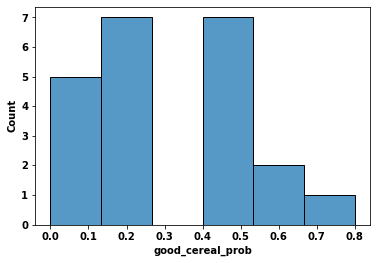

In [74]:
test_probs_1 = neigh.predict_proba(X_test)

#converting to a dataframe to make seaborn happy
test_probs_1 = pd.DataFrame(test_probs_1, columns = ['bad_cereal_prob', 'good_cereal_prob'])

#gnerates the plot
sns.histplot(test_probs_1, x= "good_cereal_prob")